<a href="https://colab.research.google.com/github/akshitt/GAN/blob/main/DCGAN_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [ ]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
10.1
1
True


In [ ]:
def mnist_data():
  compose = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  return datasets.MNIST(root='./data', train = True, transform=compose, download=True)

data = mnist_data()

batch = 128
data_loader = DataLoader(data, batch_size=batch, shuffle =True)
num_batches = len(data_loader)
print(num_batches)

469


torch.Size([128, 1, 28, 28])


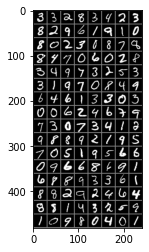

In [ ]:
#display some images 
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  #plt.imshow(np.transpose(img, (1, 2, 0)))
  #print(img.shape)
  img =img/2 +0.5
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
  plt.show()

dataiter = iter(data_loader)
images, labels = dataiter.next()

print(images.shape)
imshow(torchvision.utils.make_grid(images))
#print(' '.join('%10s' % [labels[i]] for i in range(4)))

In [ ]:
def weights_init(m):
  classmate = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm' != -1):
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    self.main1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Dropout(0.3),

      nn.Conv2d(64, 128, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Dropout(0.3),

      nn.Conv2d(128, 128, kernel_size = 5, stride = 1, padding = 2, bias = False),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Dropout(0.3)
    )

    self.main2 = nn.Sequential(
      nn.Linear(7*7*128, 1),
      nn.Sigmoid()
    )

    '''nn.Conv2d(256, 512, kernel_size = 5, stride = 2, padding =2, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1024, kernel_size = 5, stride = 1, padding = 2, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(1024, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.Sigmoid()'''
    
  def forward(self, x):
    x = self.main1(x)
    x = torch.flatten(x, 1, 3)
    x = self.main2(x)

    return x

discriminator = DiscriminatorNet().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
print(discriminator)

DiscriminatorNet(
  (main1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
  )
  (main2): Sequential(
    (0): Linear(in_features=6272, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)

In [ ]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.lin = nn.Linear(100, 7*7*256)
    self.main = nn.Sequential(
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(256, 128, kernel_size = 5, stride = 1, padding = 2, bias =False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(128, 128, kernel_size = 5, stride = 1, padding = 2, bias =False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(64, 1, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.Tanh()
    )
    

  def forward(self, x):
    #print(x)
    x = self.lin(x)
    x = x.reshape(-1, 256, 7, 7)
    x = self.main(x)
    #print(x.shape)
    return x

generator = GeneratorNet().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

loss = nn.BCELoss()

print(generator)
print(loss)

GeneratorNet(
  (lin): Linear(in_features=100, out_features=12544, bias=True)
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ConvTranspose2d(64, 1, ke

In [ ]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  return n.to(device)

In [ ]:
def ones_target(size):
  data = Variable(torch.ones(size, 1))
  return data.to(device)

def zeros_target(size):
  data = Variable(torch.zeros(size, 1))
  return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)
  optimizer.zero_grad()

  prediction_real = discriminator(vectors_to_images(real_data)).to(device)
  loss_real = loss(prediction_real.reshape(-1, 1), ones_target(N))
  loss_real.backward()

  prediction_fake = discriminator(vectors_to_images(fake_data)).to(device)
  loss_fake = loss(prediction_fake.reshape(-1, 1), zeros_target(N))
  loss_fake.backward()

  optimizer.step()

  return loss_real+loss_fake, prediction_real, prediction_fake

In [ ]:
def train_generator(optimizer, fake_data):
  N = fake_data.size(0)
  optimizer.zero_grad()

  prediction_fake = discriminator(vectors_to_images(fake_data)).to(device)
  loss_gen = loss(prediction_fake.reshape(-1, 1), ones_target(N))
  loss_gen.backward()

  optimizer.step()

  return loss_gen

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [ ]:
def fit(num_epochs = 160):
  G_losses = []
  D_losses = []
  for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    for num_iter, (real_batch, _) in enumerate(data_loader):
      #print(real_batch.size(0))
      N = real_batch.size(0)
      #print(noise(N))

      real_data = Variable(images_to_vectors(real_batch)).to(device)
      fake_data = generator(noise(N)).to(device)
      d_loss_now, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data.detach())
      d_loss += d_loss_now

      fake_data = generator(noise(N)).to(device)
      g_loss_now = train_generator(g_optimizer, fake_data)
      g_loss += g_loss_now

    D_losses.append(d_loss)
    G_losses.append(g_loss)
    print("Epoch no - " + str(epoch+1))
    print("Discriminator Loss : %f \t Generator_loss : %f" % (d_loss.item(), g_loss.item()))
    print("Accuracy on Real Data : %f \t Accuracy on fake Data : %f" % (d_pred_real.mean().item(), d_pred_fake.mean().item()))

    if((epoch+1)%10 ==0):
      with torch.no_grad():
        generated_data = generator(test_noise.detach())
        imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(G_losses,label="G")
  plt.plot(D_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
    


Epoch no - 1
Discriminator Loss : 488.099121 	 Generator_loss : 753.933899
Accuracy on Real Data : 0.746242 	 Accuracy on fake Data : 0.206515
Epoch no - 2
Discriminator Loss : 488.642761 	 Generator_loss : 742.174438
Accuracy on Real Data : 0.646312 	 Accuracy on fake Data : 0.334562
Epoch no - 3
Discriminator Loss : 511.745636 	 Generator_loss : 614.787231
Accuracy on Real Data : 0.550075 	 Accuracy on fake Data : 0.328635
Epoch no - 4
Discriminator Loss : 589.870544 	 Generator_loss : 426.885895
Accuracy on Real Data : 0.561249 	 Accuracy on fake Data : 0.417486
Epoch no - 5
Discriminator Loss : 596.683899 	 Generator_loss : 423.442505
Accuracy on Real Data : 0.529528 	 Accuracy on fake Data : 0.447025
Epoch no - 6
Discriminator Loss : 597.621948 	 Generator_loss : 424.990662
Accuracy on Real Data : 0.581114 	 Accuracy on fake Data : 0.501337
Epoch no - 7
Discriminator Loss : 601.502502 	 Generator_loss : 420.884369
Accuracy on Real Data : 0.523016 	 Accuracy on fake Data : 0.420360

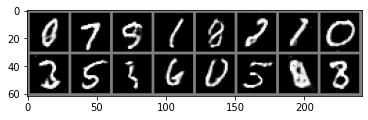

Epoch no - 11
Discriminator Loss : 614.486633 	 Generator_loss : 406.301514
Accuracy on Real Data : 0.539445 	 Accuracy on fake Data : 0.463085
Epoch no - 12
Discriminator Loss : 614.824341 	 Generator_loss : 400.001648
Accuracy on Real Data : 0.548290 	 Accuracy on fake Data : 0.516232
Epoch no - 13
Discriminator Loss : 616.108337 	 Generator_loss : 398.423767
Accuracy on Real Data : 0.547966 	 Accuracy on fake Data : 0.480222
Epoch no - 14
Discriminator Loss : 615.715027 	 Generator_loss : 398.725372
Accuracy on Real Data : 0.536499 	 Accuracy on fake Data : 0.456374
Epoch no - 15
Discriminator Loss : 616.375854 	 Generator_loss : 397.037781
Accuracy on Real Data : 0.555907 	 Accuracy on fake Data : 0.478230
Epoch no - 16
Discriminator Loss : 617.530884 	 Generator_loss : 392.013672
Accuracy on Real Data : 0.502867 	 Accuracy on fake Data : 0.439091
Epoch no - 17
Discriminator Loss : 617.927063 	 Generator_loss : 394.418091
Accuracy on Real Data : 0.525519 	 Accuracy on fake Data : 0

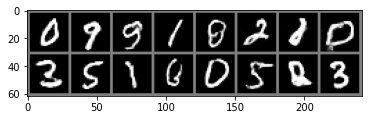

Epoch no - 21
Discriminator Loss : 620.659790 	 Generator_loss : 385.293365
Accuracy on Real Data : 0.527485 	 Accuracy on fake Data : 0.467801
Epoch no - 22
Discriminator Loss : 621.447266 	 Generator_loss : 384.088165
Accuracy on Real Data : 0.566048 	 Accuracy on fake Data : 0.475379
Epoch no - 23
Discriminator Loss : 620.537842 	 Generator_loss : 384.195740
Accuracy on Real Data : 0.542770 	 Accuracy on fake Data : 0.484301
Epoch no - 24
Discriminator Loss : 622.460083 	 Generator_loss : 383.255035
Accuracy on Real Data : 0.516642 	 Accuracy on fake Data : 0.473505
Epoch no - 25
Discriminator Loss : 622.230225 	 Generator_loss : 382.018127
Accuracy on Real Data : 0.516577 	 Accuracy on fake Data : 0.472921
Epoch no - 26
Discriminator Loss : 620.967407 	 Generator_loss : 382.280853
Accuracy on Real Data : 0.477025 	 Accuracy on fake Data : 0.433183
Epoch no - 27
Discriminator Loss : 621.222900 	 Generator_loss : 380.759155
Accuracy on Real Data : 0.497238 	 Accuracy on fake Data : 0

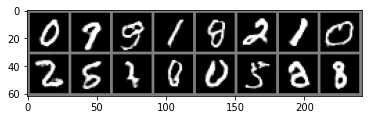

Epoch no - 31
Discriminator Loss : 621.057251 	 Generator_loss : 383.791412
Accuracy on Real Data : 0.585225 	 Accuracy on fake Data : 0.502217
Epoch no - 32
Discriminator Loss : 620.804260 	 Generator_loss : 381.993408
Accuracy on Real Data : 0.534635 	 Accuracy on fake Data : 0.468577
Epoch no - 33
Discriminator Loss : 621.119629 	 Generator_loss : 383.975861
Accuracy on Real Data : 0.494585 	 Accuracy on fake Data : 0.448007
Epoch no - 34
Discriminator Loss : 619.254395 	 Generator_loss : 382.968719
Accuracy on Real Data : 0.563271 	 Accuracy on fake Data : 0.486050
Epoch no - 35
Discriminator Loss : 619.523499 	 Generator_loss : 382.306519
Accuracy on Real Data : 0.551861 	 Accuracy on fake Data : 0.493595
Epoch no - 36
Discriminator Loss : 619.982910 	 Generator_loss : 386.050537
Accuracy on Real Data : 0.506093 	 Accuracy on fake Data : 0.436586
Epoch no - 37
Discriminator Loss : 619.502808 	 Generator_loss : 384.075287
Accuracy on Real Data : 0.547363 	 Accuracy on fake Data : 0

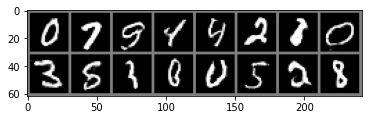

Epoch no - 41
Discriminator Loss : 618.749695 	 Generator_loss : 386.121857
Accuracy on Real Data : 0.502267 	 Accuracy on fake Data : 0.423449
Epoch no - 42
Discriminator Loss : 619.408142 	 Generator_loss : 384.619537
Accuracy on Real Data : 0.512251 	 Accuracy on fake Data : 0.516323
Epoch no - 43
Discriminator Loss : 617.899780 	 Generator_loss : 384.901062
Accuracy on Real Data : 0.502708 	 Accuracy on fake Data : 0.481123
Epoch no - 44
Discriminator Loss : 618.836914 	 Generator_loss : 386.871002
Accuracy on Real Data : 0.548750 	 Accuracy on fake Data : 0.493400
Epoch no - 45
Discriminator Loss : 617.202881 	 Generator_loss : 384.413818
Accuracy on Real Data : 0.514684 	 Accuracy on fake Data : 0.480778
Epoch no - 46
Discriminator Loss : 616.981262 	 Generator_loss : 387.547180
Accuracy on Real Data : 0.540704 	 Accuracy on fake Data : 0.422760
Epoch no - 47
Discriminator Loss : 618.359436 	 Generator_loss : 386.581360
Accuracy on Real Data : 0.517750 	 Accuracy on fake Data : 0

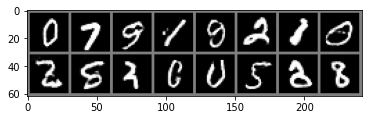

Epoch no - 51
Discriminator Loss : 618.141174 	 Generator_loss : 388.041534
Accuracy on Real Data : 0.503335 	 Accuracy on fake Data : 0.449392
Epoch no - 52
Discriminator Loss : 616.603821 	 Generator_loss : 387.759186
Accuracy on Real Data : 0.531168 	 Accuracy on fake Data : 0.443400
Epoch no - 53
Discriminator Loss : 617.027954 	 Generator_loss : 387.396027
Accuracy on Real Data : 0.547910 	 Accuracy on fake Data : 0.507788
Epoch no - 54
Discriminator Loss : 616.723389 	 Generator_loss : 388.400574
Accuracy on Real Data : 0.475253 	 Accuracy on fake Data : 0.404592
Epoch no - 55
Discriminator Loss : 617.375122 	 Generator_loss : 388.048492
Accuracy on Real Data : 0.465425 	 Accuracy on fake Data : 0.410820
Epoch no - 56
Discriminator Loss : 617.064697 	 Generator_loss : 388.504639
Accuracy on Real Data : 0.536757 	 Accuracy on fake Data : 0.433803
Epoch no - 57
Discriminator Loss : 616.508301 	 Generator_loss : 388.582428
Accuracy on Real Data : 0.541811 	 Accuracy on fake Data : 0

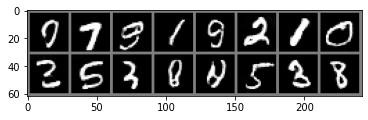

Epoch no - 61
Discriminator Loss : 615.290222 	 Generator_loss : 391.498901
Accuracy on Real Data : 0.489482 	 Accuracy on fake Data : 0.412966
Epoch no - 62
Discriminator Loss : 615.861145 	 Generator_loss : 389.108521
Accuracy on Real Data : 0.547378 	 Accuracy on fake Data : 0.450182
Epoch no - 63
Discriminator Loss : 615.421570 	 Generator_loss : 390.615387
Accuracy on Real Data : 0.468805 	 Accuracy on fake Data : 0.436771
Epoch no - 64
Discriminator Loss : 616.119690 	 Generator_loss : 390.060822
Accuracy on Real Data : 0.536512 	 Accuracy on fake Data : 0.465433
Epoch no - 65
Discriminator Loss : 614.605652 	 Generator_loss : 388.961212
Accuracy on Real Data : 0.546170 	 Accuracy on fake Data : 0.450767
Epoch no - 66
Discriminator Loss : 614.044922 	 Generator_loss : 390.733063
Accuracy on Real Data : 0.558321 	 Accuracy on fake Data : 0.442382
Epoch no - 67
Discriminator Loss : 614.824036 	 Generator_loss : 389.696564
Accuracy on Real Data : 0.487861 	 Accuracy on fake Data : 0

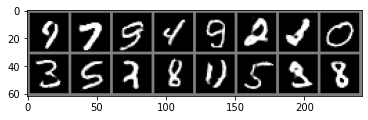

Epoch no - 71
Discriminator Loss : 615.956116 	 Generator_loss : 389.599976
Accuracy on Real Data : 0.538891 	 Accuracy on fake Data : 0.462478
Epoch no - 72
Discriminator Loss : 613.448547 	 Generator_loss : 390.119965
Accuracy on Real Data : 0.550241 	 Accuracy on fake Data : 0.457684
Epoch no - 73
Discriminator Loss : 613.812195 	 Generator_loss : 390.901031
Accuracy on Real Data : 0.529258 	 Accuracy on fake Data : 0.478816
Epoch no - 74
Discriminator Loss : 614.994385 	 Generator_loss : 390.032196
Accuracy on Real Data : 0.554081 	 Accuracy on fake Data : 0.508552
Epoch no - 75
Discriminator Loss : 613.877014 	 Generator_loss : 391.771088
Accuracy on Real Data : 0.566505 	 Accuracy on fake Data : 0.506758
Epoch no - 76
Discriminator Loss : 615.299194 	 Generator_loss : 390.599609
Accuracy on Real Data : 0.527538 	 Accuracy on fake Data : 0.461056
Epoch no - 77
Discriminator Loss : 615.687866 	 Generator_loss : 391.232544
Accuracy on Real Data : 0.532995 	 Accuracy on fake Data : 0

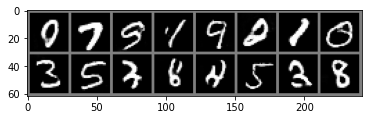

Epoch no - 81
Discriminator Loss : 613.952271 	 Generator_loss : 393.289001
Accuracy on Real Data : 0.517896 	 Accuracy on fake Data : 0.484360
Epoch no - 82
Discriminator Loss : 612.939697 	 Generator_loss : 389.904846
Accuracy on Real Data : 0.567728 	 Accuracy on fake Data : 0.443936
Epoch no - 83
Discriminator Loss : 613.851318 	 Generator_loss : 392.175659
Accuracy on Real Data : 0.536391 	 Accuracy on fake Data : 0.462321
Epoch no - 84
Discriminator Loss : 615.033752 	 Generator_loss : 393.201447
Accuracy on Real Data : 0.502722 	 Accuracy on fake Data : 0.423571
Epoch no - 85
Discriminator Loss : 613.467651 	 Generator_loss : 392.789368
Accuracy on Real Data : 0.539299 	 Accuracy on fake Data : 0.486675
Epoch no - 86
Discriminator Loss : 613.594238 	 Generator_loss : 391.358063
Accuracy on Real Data : 0.495461 	 Accuracy on fake Data : 0.436937
Epoch no - 87
Discriminator Loss : 612.997437 	 Generator_loss : 392.368835
Accuracy on Real Data : 0.533283 	 Accuracy on fake Data : 0

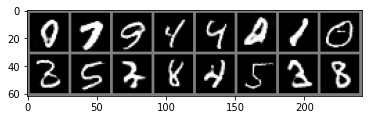

Epoch no - 91
Discriminator Loss : 612.776062 	 Generator_loss : 392.515472
Accuracy on Real Data : 0.550095 	 Accuracy on fake Data : 0.481298
Epoch no - 92
Discriminator Loss : 613.339966 	 Generator_loss : 391.851379
Accuracy on Real Data : 0.510726 	 Accuracy on fake Data : 0.456844
Epoch no - 93
Discriminator Loss : 613.295532 	 Generator_loss : 392.409210
Accuracy on Real Data : 0.524476 	 Accuracy on fake Data : 0.448251
Epoch no - 94
Discriminator Loss : 612.123169 	 Generator_loss : 392.791473
Accuracy on Real Data : 0.545627 	 Accuracy on fake Data : 0.452453
Epoch no - 95
Discriminator Loss : 613.212280 	 Generator_loss : 394.975647
Accuracy on Real Data : 0.546090 	 Accuracy on fake Data : 0.458381
Epoch no - 96
Discriminator Loss : 613.981445 	 Generator_loss : 391.781738
Accuracy on Real Data : 0.478655 	 Accuracy on fake Data : 0.457895
Epoch no - 97
Discriminator Loss : 613.026794 	 Generator_loss : 392.707550
Accuracy on Real Data : 0.534287 	 Accuracy on fake Data : 0

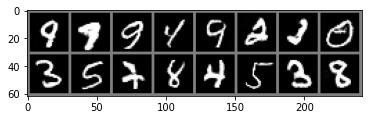

Epoch no - 101
Discriminator Loss : 612.626526 	 Generator_loss : 392.100983
Accuracy on Real Data : 0.537948 	 Accuracy on fake Data : 0.439794
Epoch no - 102
Discriminator Loss : 612.923523 	 Generator_loss : 394.195129
Accuracy on Real Data : 0.532135 	 Accuracy on fake Data : 0.438581
Epoch no - 103
Discriminator Loss : 613.292786 	 Generator_loss : 393.705872
Accuracy on Real Data : 0.567274 	 Accuracy on fake Data : 0.462101
Epoch no - 104
Discriminator Loss : 613.011108 	 Generator_loss : 393.860291
Accuracy on Real Data : 0.563480 	 Accuracy on fake Data : 0.469766
Epoch no - 105
Discriminator Loss : 612.043945 	 Generator_loss : 392.848297
Accuracy on Real Data : 0.576248 	 Accuracy on fake Data : 0.484030
Epoch no - 106
Discriminator Loss : 612.620361 	 Generator_loss : 394.731262
Accuracy on Real Data : 0.533296 	 Accuracy on fake Data : 0.459626
Epoch no - 107
Discriminator Loss : 611.798462 	 Generator_loss : 394.076569
Accuracy on Real Data : 0.508853 	 Accuracy on fake D

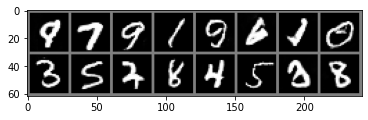

Epoch no - 111
Discriminator Loss : 611.930847 	 Generator_loss : 394.706512
Accuracy on Real Data : 0.583006 	 Accuracy on fake Data : 0.497770
Epoch no - 112
Discriminator Loss : 611.916809 	 Generator_loss : 394.368378
Accuracy on Real Data : 0.564961 	 Accuracy on fake Data : 0.489137
Epoch no - 113
Discriminator Loss : 612.020691 	 Generator_loss : 396.487885
Accuracy on Real Data : 0.516273 	 Accuracy on fake Data : 0.460689
Epoch no - 114
Discriminator Loss : 611.844177 	 Generator_loss : 395.655334
Accuracy on Real Data : 0.551434 	 Accuracy on fake Data : 0.501397
Epoch no - 115
Discriminator Loss : 612.069397 	 Generator_loss : 393.468353
Accuracy on Real Data : 0.550495 	 Accuracy on fake Data : 0.502544
Epoch no - 116
Discriminator Loss : 613.037720 	 Generator_loss : 395.277496
Accuracy on Real Data : 0.517906 	 Accuracy on fake Data : 0.463048
Epoch no - 117
Discriminator Loss : 610.745972 	 Generator_loss : 395.362976
Accuracy on Real Data : 0.535705 	 Accuracy on fake D

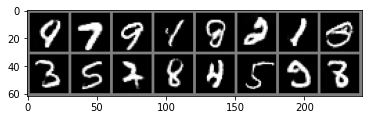

Epoch no - 121
Discriminator Loss : 611.634338 	 Generator_loss : 395.181427
Accuracy on Real Data : 0.539263 	 Accuracy on fake Data : 0.506238
Epoch no - 122
Discriminator Loss : 611.693298 	 Generator_loss : 395.381714
Accuracy on Real Data : 0.534526 	 Accuracy on fake Data : 0.444012
Epoch no - 123
Discriminator Loss : 612.139099 	 Generator_loss : 394.110138
Accuracy on Real Data : 0.545043 	 Accuracy on fake Data : 0.441913
Epoch no - 124
Discriminator Loss : 611.466431 	 Generator_loss : 394.198730
Accuracy on Real Data : 0.526113 	 Accuracy on fake Data : 0.439758
Epoch no - 125
Discriminator Loss : 610.976929 	 Generator_loss : 397.901337
Accuracy on Real Data : 0.556436 	 Accuracy on fake Data : 0.459223
Epoch no - 126
Discriminator Loss : 612.078613 	 Generator_loss : 395.564026
Accuracy on Real Data : 0.538203 	 Accuracy on fake Data : 0.456781
Epoch no - 127
Discriminator Loss : 611.370972 	 Generator_loss : 393.937988
Accuracy on Real Data : 0.528170 	 Accuracy on fake D

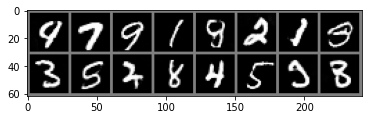

Epoch no - 131
Discriminator Loss : 610.903442 	 Generator_loss : 396.867188
Accuracy on Real Data : 0.593644 	 Accuracy on fake Data : 0.494799
Epoch no - 132
Discriminator Loss : 611.913940 	 Generator_loss : 393.231110
Accuracy on Real Data : 0.551977 	 Accuracy on fake Data : 0.467381
Epoch no - 133
Discriminator Loss : 610.948181 	 Generator_loss : 395.992950
Accuracy on Real Data : 0.562926 	 Accuracy on fake Data : 0.459720
Epoch no - 134
Discriminator Loss : 612.599548 	 Generator_loss : 396.225281
Accuracy on Real Data : 0.552861 	 Accuracy on fake Data : 0.464076
Epoch no - 135
Discriminator Loss : 611.729065 	 Generator_loss : 394.565186
Accuracy on Real Data : 0.532932 	 Accuracy on fake Data : 0.446508
Epoch no - 136
Discriminator Loss : 612.739441 	 Generator_loss : 392.912964
Accuracy on Real Data : 0.507457 	 Accuracy on fake Data : 0.420929
Epoch no - 137
Discriminator Loss : 612.087830 	 Generator_loss : 392.826141
Accuracy on Real Data : 0.593984 	 Accuracy on fake D

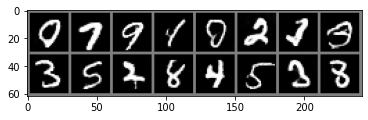

Epoch no - 141
Discriminator Loss : 611.142151 	 Generator_loss : 394.557617
Accuracy on Real Data : 0.559594 	 Accuracy on fake Data : 0.489176
Epoch no - 142
Discriminator Loss : 613.608643 	 Generator_loss : 395.303192
Accuracy on Real Data : 0.536894 	 Accuracy on fake Data : 0.453819
Epoch no - 143
Discriminator Loss : 611.106445 	 Generator_loss : 393.076599
Accuracy on Real Data : 0.516678 	 Accuracy on fake Data : 0.425371
Epoch no - 144
Discriminator Loss : 611.699585 	 Generator_loss : 394.428802
Accuracy on Real Data : 0.535786 	 Accuracy on fake Data : 0.441302
Epoch no - 145
Discriminator Loss : 613.395142 	 Generator_loss : 394.966278
Accuracy on Real Data : 0.532281 	 Accuracy on fake Data : 0.449338
Epoch no - 146
Discriminator Loss : 612.169556 	 Generator_loss : 394.597565
Accuracy on Real Data : 0.609235 	 Accuracy on fake Data : 0.519339
Epoch no - 147
Discriminator Loss : 612.072937 	 Generator_loss : 392.942932
Accuracy on Real Data : 0.530505 	 Accuracy on fake D

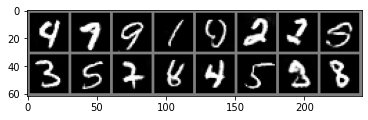

Epoch no - 151
Discriminator Loss : 611.179932 	 Generator_loss : 394.754456
Accuracy on Real Data : 0.533518 	 Accuracy on fake Data : 0.415660
Epoch no - 152
Discriminator Loss : 612.400879 	 Generator_loss : 393.832764
Accuracy on Real Data : 0.532748 	 Accuracy on fake Data : 0.464643
Epoch no - 153
Discriminator Loss : 613.348755 	 Generator_loss : 393.960205
Accuracy on Real Data : 0.535398 	 Accuracy on fake Data : 0.453422
Epoch no - 154
Discriminator Loss : 611.208008 	 Generator_loss : 394.339142
Accuracy on Real Data : 0.544101 	 Accuracy on fake Data : 0.467504
Epoch no - 155
Discriminator Loss : 613.207825 	 Generator_loss : 395.034760
Accuracy on Real Data : 0.537964 	 Accuracy on fake Data : 0.430887
Epoch no - 156
Discriminator Loss : 613.562622 	 Generator_loss : 391.789337
Accuracy on Real Data : 0.517154 	 Accuracy on fake Data : 0.420519
Epoch no - 157
Discriminator Loss : 613.186096 	 Generator_loss : 391.898956
Accuracy on Real Data : 0.458605 	 Accuracy on fake D

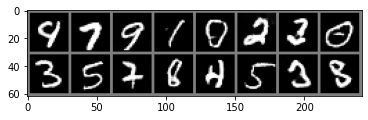

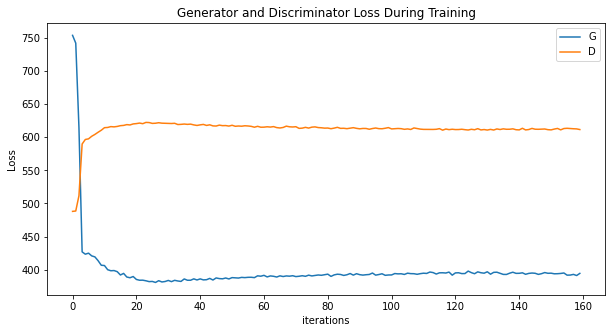

In [ ]:
fit()